# Снятие омонимии на корпусе Taiga

In [1]:
import random
from glob import glob
from conllu import parse
from tqdm import tqdm

In [2]:
text_files = glob('NPlus1/home/tsha/NPlus1/tagged_texts/*.txt')
len(text_files)

7696

In [3]:
dataset = []

for text_file in tqdm(text_files):
    with open(text_file, 'r', encoding='utf-8') as f:
        text = f.read()
        sentences = parse(text)
        for sent in sentences:
            sample = []
            for i in sent:
                sample.append((i['form'].lower(), i['upos']))
            dataset.append(sample)

print(len(dataset))

100%|██████████| 7696/7696 [00:29<00:00, 265.25it/s]

90126


In [4]:
omonimous_words = set()
vocab = {}
for sample in dataset:
    for word, pos in sample:
        if word not in vocab:
            vocab[word] = set()
        vocab[word].add(pos)
        if len(vocab[word]) > 1:
            omonimous_words.add(word)

print(len(omonimous_words))

10227


In [5]:
words = list(vocab.keys())
pos_tags = set()
for word in words:
    pos_tags.update(vocab[word])
pos_tags = list(pos_tags)
pos_tags.append("MASK")

In [6]:
words_ids = {word: i for i, word in enumerate(words)}
pos_tags_ids = {pos: i for i, pos in enumerate(pos_tags)}

In [7]:
pos_tags_ids

{'INTJ': 0,
 'PROPN': 1,
 'PART': 2,
 'NUM': 3,
 'ADV': 4,
 'NOUN': 5,
 'AUX': 6,
 'ADP': 7,
 'VERB': 8,
 'DET': 9,
 'PRON': 10,
 'X': 11,
 'ADJ': 12,
 'PUNCT': 13,
 'SYM': 14,
 'SCONJ': 15,
 'CCONJ': 16,
 'MASK': 17}

In [8]:
tokenized_dataset = []

for sample in tqdm(dataset):
    tokenized_sample = []
    for word, pos in sample:
        tokenized_sample.append([words_ids[word], pos_tags_ids[pos]])
    tokenized_dataset.append(tokenized_sample)

100%|██████████| 90126/90126 [00:02<00:00, 37541.84it/s]


In [9]:
tokenized_dataset[0]

[[0, 12],
 [1, 5],
 [2, 13],
 [3, 12],
 [4, 5],
 [5, 1],
 [6, 8],
 [7, 9],
 [8, 5],
 [9, 5],
 [10, 13],
 [11, 1],
 [10, 13],
 [12, 13],
 [13, 15],
 [14, 12],
 [15, 5],
 [16, 9],
 [17, 5],
 [18, 7],
 [19, 5],
 [20, 5],
 [21, 13]]

In [10]:
def mask_omonimous_word(sample, probability=0.1):
    masked_sample = []
    for word, pos in sample:
        if words[word] in omonimous_words and random.random() < probability:
            masked_sample.append([word, 17])  # -1 indicates a masked POS tag
        else:
            masked_sample.append([word, pos])
    return masked_sample

In [11]:
dataset_masked = []
for sample in tqdm(tokenized_dataset):
    masked_sample = mask_omonimous_word(sample)
    dataset_masked.append(masked_sample)

100%|██████████| 90126/90126 [00:01<00:00, 57249.66it/s] 


In [12]:
dataset_train, dataset_test = dataset_masked[:int(0.8 * len(dataset_masked))], dataset_masked[int(0.8 * len(dataset_masked)):]
print(f'Train size: {len(dataset_train)}, Test size: {len(dataset_test)}')

Train size: 72100, Test size: 18026


In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score, classification_report
import numpy as np

features = []
labels = []
mask_positions = []

for sample in dataset_masked:
    sample_features = []
    sample_labels = []
    sample_mask_pos = []
    for i, (word_id, pos_id) in enumerate(sample):
        sample_features.append(word_id)
        if pos_id == 17:
            sample_labels.append(17)
            sample_mask_pos.append(i)
        else:
            sample_labels.append(pos_id)
            
    features.append(sample_features)
    labels.append(sample_labels)
    mask_positions.append(sample_mask_pos)

max_len = max(len(f) for f in features)
padded_features = [seq + [0] * (max_len - len(seq)) for seq in features]
padded_labels = [seq + [-100] * (max_len - len(seq)) for seq in labels]

features_tensor = torch.LongTensor(padded_features)
labels_tensor = torch.LongTensor(padded_labels)

In [14]:
class POSDataset(Dataset):
    def __init__(self, features, labels) -> None:
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]
    
dataset = POSDataset(features_tensor, labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class POSModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(POSModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [23]:
vocab_size = len(words)
embedding_dim = 128
hidden_size = 64
output_size = len(pos_tags)
learning_rate = 0.001
epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = POSModel(vocab_size, embedding_dim, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()  # Ensure model is in training mode
    for batch_features, batch_labels in tqdm(train_loader):
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs.view(-1, output_size), batch_labels.view(-1))
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for test_features, test_labels in test_loader:
            test_features = test_features.to(device)
            test_labels = test_labels.to(device)

            outputs = model(test_features)
            test_loss += criterion(outputs.view(-1, output_size), test_labels.view(-1)).item()

    test_loss /= len(test_loader)  # Average test loss
    train_losses.append(loss.item())
    test_losses.append(test_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')

Using device: cuda


100%|██████████| 1127/1127 [00:18<00:00, 60.25it/s]


Epoch [1/5], Loss: 0.4955, Test Loss: 0.5550


100%|██████████| 1127/1127 [00:18<00:00, 61.36it/s]


Epoch [2/5], Loss: 0.3646, Test Loss: 0.4159


100%|██████████| 1127/1127 [00:18<00:00, 60.77it/s]


Epoch [3/5], Loss: 0.3235, Test Loss: 0.3671


100%|██████████| 1127/1127 [00:18<00:00, 61.34it/s]


Epoch [4/5], Loss: 0.2299, Test Loss: 0.3495


100%|██████████| 1127/1127 [00:18<00:00, 61.60it/s]


Epoch [5/5], Loss: 0.2066, Test Loss: 0.3460


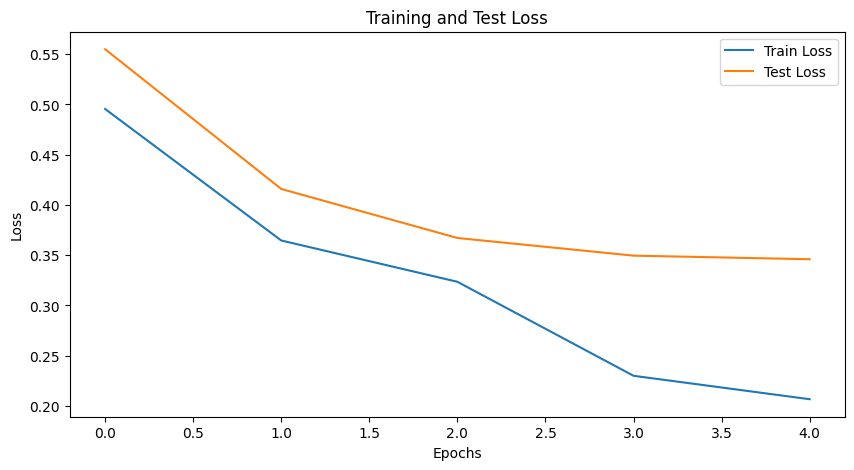

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

In [39]:
def predict(words, pos_tags, model):
    model.eval()
    with torch.no_grad():
        inputs = torch.LongTensor([words_ids[word] for word in words]).unsqueeze(0).to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=2)
        print(predicted.squeeze(0))
        for i in predicted.squeeze(0):
            print(i.item())
            print(pos_tags[i.item()], end=' ')
    #     predicted_pos = [pos_tags[p.item()] for p in predicted[0]]
    # return predicted_pos

print(
    predict(["мы", "стали", "старше"], ["PRON", "MASK", "ADV"], model)
)

tensor([10,  8, 12], device='cuda:0')
10


IndexError: list index out of range